In [11]:
# Standard imports
import numpy as np
from matplotlib import pyplot as plt

# import tensorflow as tf
from time import time
import pandas as pd

from ot.lp import emd2

from src.utils.plot_utils import load_data, plot, plot_event, make_gif, timer_func
from utils import load_dataset

(100000, 200, 3)
171.30413009311044
158.9693130074576
161.6709548277763
217.78496066391168
157.1739932749623
145.224438230974
210.35511596145994
177.41657786466106
162.74283877110196
163.63866635517257
170.3576439203059
184.45016632605598
141.4605829588729
175.44704442677346
184.92676363567008
162.4442373605805
148.9623001817155
165.37205399302044
188.76134723766813
196.78699343734533
159.86244258701095
141.6034302870565
156.7598874524902
186.42487167181534
176.3970632284652
176.03360787616168
206.68555074523508
226.98550730611316
197.07720436144035
199.08915373514188
194.02682045703895
222.23402839990294
189.07924913438973
194.60076760887804
153.22383957002594
184.61172023317496
181.1678834389061
177.36232493923788
176.75793699476736
169.7813773435615
164.98595747505686
160.1663605195856
181.10157347849085
167.8657250667833
156.9408770372269
216.71362782196286
183.82859213843093
137.17973524294436
209.40836609362938
159.55058490438918
172.14346141202506
188.02718152560792
175.92819245

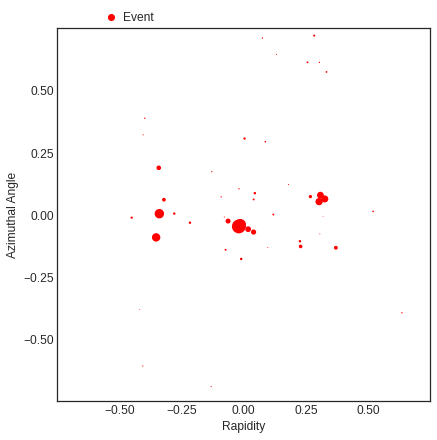

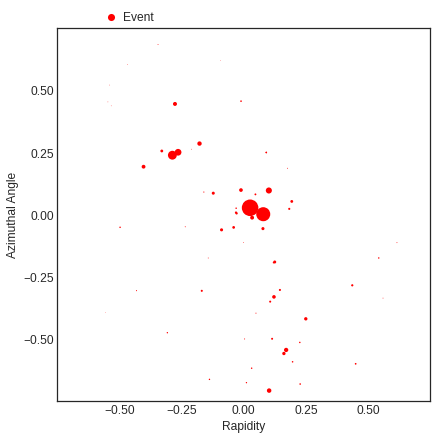

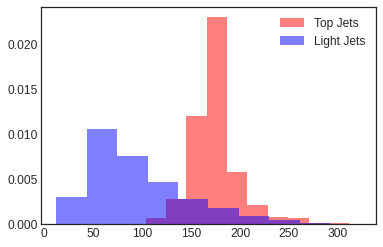

In [12]:
# Parameters
R = 0.5
beta = 1.0
N = 1000
epochs = 75
mass_lower = 145
mass_upper = 205
eta_cut = 1.3
plot_dir = "results"



signal, signal_masses = load_dataset("../Datasets/top/v0/signal_train.npy", N, mass_lower, mass_upper, eta_cut)
background, background_masses = load_dataset("../Datasets/top/v0/background_train.npy", N, mass_lower, mass_upper, eta_cut)
events = [signal, background]
event_labels = ["signal", "background"]
colors = ["red", "blue"]


fake_top, fake_top_z = np.array(( (-1.0,0.0), (0.0,0.0), (1.0,0.0),)), np.array((1/3, 1/3, 1/3))
fake_signal = ((fake_top, fake_top_z), )
fake_quark, fake_quark_z = np.array(((0.0,0.0),)), np.array((1.0, ))
fake_background = ((fake_quark, fake_quark_z),)
fake_events = [fake_signal, fake_background]


# Example plots
example_signal = signal[0]
plot_event(example_signal[0], example_signal[1], R, color = "red")

example_background = background[0]
plot_event(example_background[0], example_background[1], R, color = "blue")

plt.hist(signal_masses, color = "red", alpha = 0.5, label = "Top Jets", density = True)
plt.hist(background_masses, color = "blue", alpha = 0.5, label = "Light Jets", density = True)
plt.legend()


## POT

In [13]:
n = 25

points = []
zs = []

for y in np.linspace(-0.8, 0.8, n):
    for phi in np.linspace(-0.8, 0.8, n):

        points.append((y, phi))
        zs.append(1.0 / (n**2))


refernce_event = (np.array(points), np.array(zs))

In [27]:
emds_old = np.zeros(shape = (len(events), N))
times_old = np.zeros(shape = (len(events), N))

def _cdist_phi_y(X,Y, ym):
    # define ym as the maximum rapidity cut on the quasi-isotropic event
    # Make sure the phi values are in range                                                                                                                                          
    phi1 = (X[:,1])
    phi2 = (Y[:,1])
    # Trick to account for phi distance periodicity
    phi_d = ((phi1[:,np.newaxis] - phi2[:])) 
    norm = 12.0/(np.pi*np.pi+16*ym*ym)
    y_d = X[:,0,np.newaxis] - Y[:,0]
    dist = norm * (phi_d**2 + y_d**2)
    return dist

# Calculate the EMDs for each observable, for each event
for (i, event_type) in enumerate(events):
        for (k, event) in enumerate(events[i]):

            t1 = time()
            xi, ai = event
            yj, bj = refernce_event
            M = _cdist_phi_y(xi, yj, 0.8)
            emd_val, log = emd2(ai.astype(np.float64) / ai.sum().astype(np.float64), bj.astype(np.float64)/ bj.sum().astype(np.float64), M,log=True)
            # Should only return 0 when two events are identical. If returning 0 otherwise, problems in config
            if emd_val==0:
                print(log['warning'])
            emds_old[i,k] = emd_val
            t2 = time()
            times_old[i,k] = t2 - t1

            print("Event %d" %k, "Class: %s" % event_labels[i], "Value: %.6f" % emd_val, "Finished in %.3fs" % (t2 - t1))

print(np.sum(times_old))

Event 0 Class: signal Value: 0.151632 Finished in 0.011s
Event 1 Class: signal Value: 0.141561 Finished in 0.010s
Event 2 Class: signal Value: 0.170037 Finished in 0.012s
Event 3 Class: signal Value: 0.158041 Finished in 0.015s
Event 4 Class: signal Value: 0.181990 Finished in 0.009s
Event 5 Class: signal Value: 0.138684 Finished in 0.015s
Event 6 Class: signal Value: 0.170285 Finished in 0.012s
Event 7 Class: signal Value: 0.151670 Finished in 0.012s
Event 8 Class: signal Value: 0.156131 Finished in 0.008s
Event 9 Class: signal Value: 0.142430 Finished in 0.011s
Event 10 Class: signal Value: 0.155755 Finished in 0.013s
Event 11 Class: signal Value: 0.156024 Finished in 0.007s
Event 12 Class: signal Value: 0.173553 Finished in 0.006s
Event 13 Class: signal Value: 0.151563 Finished in 0.012s
Event 14 Class: signal Value: 0.165268 Finished in 0.010s
Event 15 Class: signal Value: 0.130452 Finished in 0.009s
Event 16 Class: signal Value: 0.131095 Finished in 0.012s
Event 17 Class: signal V

## Sinkhorn

In [15]:
import torch
from torch.autograd import grad
from torch import optim
from geomloss import SamplesLoss
from pyjet import cluster

use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [16]:
class CoolPoint(object):

    def __init__(self, mean, z, N = 1):

        self.center = torch.tensor(mean)
        self.z = torch.tensor(z)
        self.N = N

        self.parameters = [self.center]

        self.t = self.sample(self.N)

        self.name = "Point"

    def initialize(self, event, R):
        self.center = torch.tensor(event[0], dtype = torch.float)
        self.z = torch.tensor(event[1], dtype = torch.float)
        self.parameters = [self.center]

    def sample(self,N):
        return self.center.reshape((1,-1))

    def get_event(self):
        self.t = self.sample(self.N)
        return (self.center.reshape(1,-1), self.z * torch.ones((self.N,)) / self.N)


    def get_zs(self):
        return self.get_event()[1].detach().numpy()

    def get_points(self):
        return self.get_event()[0].detach().numpy()

    def get_param_dict(self, loss):

        dict = {"EMD" : loss}
        dict["Center"] = self.center.clone().detach().numpy()
        dict["z"] = self.z.clone().detach().numpy()
        return dict

    def draw(self,ax):
        pass

    def print(self):
        pass

    def __str__(self):
        return "z: %.3f GeV" % (self.z.data)


class CoolUniform(object):

    def __init__(self):

        self.z = torch.tensor(1)
        self.parameters = []
        self.N = 1
        self.name = "Uniform"

    def initialize(self, event, R):
        pass

    def sample(self,N):
        return None

    def get_event(self):
        self.t = self.sample(self.N)
        return (torch.tensor(refernce_event[0]), torch.tensor(refernce_event[1]))


    def get_zs(self):
        return self.get_event()[1].detach().numpy()

    def get_points(self):
        return self.get_event()[0].detach().numpy()

    def get_param_dict(self, loss):

        dict = {"EMD" : loss}
        return dict

    def draw(self,ax):
        pass

    def print(self):
        pass

    def __str__(self):
        return "z: %.3f GeV" % (self.z.data)

class MixtureModel(object):

    def __init__(self, shapes = None):

        self.shapes = shapes
        self.ids = range(len(shapes))
        self.zs = [shape.z for shape in self.shapes]
        self.parameters = []
        for shape in shapes:
            self.parameters += shape.parameters
        

    def get_event(self):
        event = concatenate_events([shape.get_event() for shape in self.shapes])
        return event

    def get_zs(self):
        return self.get_event()[1]

    def get_points(self):
        return self.get_event()[0]

    def initialize(self, event, R):
        points, energies = kt_initializer(event, len(self.shapes), R)
        for (i, shape) in enumerate(self.shapes):
            shape.initialize((points[i], energies[i]),R)

        self.zs = [shape.z for shape in self.shapes]
        self.parameters = []
        for shape in self.shapes:
            self.parameters += shape.parameters


    def normalize(self):
            
        z_test = activate(torch.tensor(self.zs).reshape((1, -1)))
        for (i, shape) in enumerate(self.shapes):
            shape.z.data = z_test[0,i]
        self.zs = [shape.z for shape in self.shapes]    


    def get_param_dict(self, loss):
        dict = {"EMD" : loss}
        for (i,shape) in enumerate(self.shapes):
            dict_i = shape.get_param_dict(loss)
            for key, value in dict_i.items():
                if key != "EMD":
                    dict[key + "_%d" % self.ids[i]] = value 
        return dict


def concatenate_events(events):
    points, zs = [], []
    for event in events:
        points.append(event[0])
        zs.append(event[1])
    points = torch.cat(points, dim = 0)
    zs = torch.cat(zs, dim = 0)
    return (points, zs)


def activate(x):
    m, n = x.shape
    cnt_m = torch.arange(m, device=x.device)
    cnt_n = torch.arange(n, device=x.device)
    u = x.sort(dim=1, descending=True).values
    v = (u.cumsum(dim=1) - 1) / (cnt_n + 1)
    w = v[cnt_m, (u > v).sum(dim=1) - 1]
    return (x - w.view(m, 1)).relu()


def kt_initializer(event, N, R):

    y, z = event

    four_vectors = []
    for (y_i, z_i) in zip(y, z):
        v = (z_i, y_i[0], y_i[1], 0)
        four_vectors.append(v)
    four_vectors = np.array(four_vectors, dtype = [("pt", "f8"),("eta", "f8"),("phi", "f8"),("mass", "f8")])
    sequence = cluster(four_vectors, R=R/4, p=1)
    jets = sequence.exclusive_jets(N)

    # Apply initialization
    jets = jets[:N]
    initialization = []
    energies = []
    for jet in jets:
        initialization.append([jet.eta, jet.phi])
        energies.append(jet.pt)
    initialization = np.array(initialization).astype(np.float32)
    return initialization, energies / np.sum(energies)

In [17]:

_isotropy = MixtureModel(shapes = [CoolUniform()])

_1point = MixtureModel(shapes = [CoolPoint((0.0,0.0), 1.0)])
_2point = MixtureModel(shapes = [CoolPoint((-1.0,0.0), 0.5), CoolPoint((1.0,0.0), 0.5)])
_3point = MixtureModel(shapes = [CoolPoint((-1.0,0.0), 0.333), CoolPoint((1.0,0.0), 0.333), CoolPoint((0.0,0,0), 0.333)])

observables = [_isotropy]


def train(event, observable, epochs = 500, lr = 0.05, early_stopping = 25, epsilon = 0.01, annealing = 0.99, init = True, scaling = 0.5):

    count = 0
    min_loss = np.inf
    params = {}
    
    if init:
        observable.initialize(event, R)

    event_clone = (torch.tensor(event[0], dtype = torch.float64), torch.tensor(event[1], dtype = torch.float64))

    Loss = SamplesLoss("sinkhorn", p = 2, blur = epsilon**(1/2), scaling =  scaling) 


    # Require grad:
    parameters = []
    for shape in observable.shapes:
        shape.sample(shape.N)
        for parameter in shape.parameters:
            parameter.requires_grad = True
            parameters.append(parameter)
        # shape.z.requires_grad = True


    optimizer = None



    for i in range(epochs):
        loss = train_step(event_clone, observable, optimizer, epsilon, Loss) 
        if loss < min_loss * (1 - epsilon):
            count = 0
            min_loss = loss
            params = observable.get_param_dict(min_loss)
        else:
            count += 1
        if count == early_stopping:
            break

        # lr *= annealing

    # for shape in observable.shapes:
    #     print(shape.parameters, shape.z)

    params["Epochs"] = i
    return params

def train_step(event, observable, optimizer, epsilon, Loss):


    parameters = []
    for shape in observable.shapes:
        shape.sample(shape.N)
        for parameter in shape.parameters:
            # parameter.requires_grad = True
            parameters.append(parameter)
        # shape.z.requires_grad = True


    # Create a copy of the data...
    x_i, a_i = event
    y_j, b_j = observable.get_event()

    # Compute the loss + gradients:
    
    
    Loss_xy = Loss(a_i, x_i, b_j, y_j) 

    
    observable.normalize()

    # print("Epoch = ", epoch, "Loss = ", Loss_xy , ", zs = " ,observable.zs)
    # plot(x_i.numpy(), a_i.numpy(), y_j.detach().numpy(), b_j.detach().numpy(), np.zeros((a_i.shape[0], b_j.shape[0])), Loss_xy.detach().numpy(), R, 1.0,  "temp/epoch_%d.png" % epoch,"Epoch %d" % epoch, observable.shapes)
    # # Require grad:
    # for shape in observable.shapes:
    #     shape.sample(shape.N)
    #     for parameter in shape.parameters:
    #         parameter.requires_grad = True
    #     shape.z.requires_grad = True


    return Loss_xy.detach().numpy()



In [21]:
#BEST PARAMS : EPS = 0.01, LR = 0.05, ANNEALING = 0.99, manual gradient descent, searly = 0.25
# ADAM LR = 0.05, early stopping = 25 is bad, but very fast (10 min)!
# ADAM LR = 0.05, early stopping = 50 is bad, but twice as long!
# SGD LR = 0.05, early stopping = 25 is bad AND fast (14 min) - forgot annealing! More consistent distributions hower
# SGD LR = 0.05, early stopping = 25 is good AND fast (10 min)

# Try zero grad

labels = ["Isotropy"]
epsilons = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

emds_sinkhorn = np.zeros(shape = (len(events),len(observables), len(epsilons), N))
times_sinkhorn = np.zeros(shape = (len(events),len(observables), len(epsilons), N))


# Calculate the EMDs for each observable, for each event
for (i, event_type) in enumerate(events):
    for (j, obs) in enumerate(observables):
        for (e, eps) in enumerate(epsilons):
            for (k, event) in enumerate(events[i]):

                t1 = time()
                emd = train(event, obs, epochs = 1, epsilon = 0.001, early_stopping = 25, lr = 0.05, scaling = eps)
                emds_sinkhorn[i,j,e,k] = emd["EMD"]
                t2 = time()
                times_sinkhorn[i,j,e,k] = t2 - t1

                print("Event %d" %k, "Obs: %s-%.1e" % (labels[j], eps), "Class: %s" % event_labels[i], "Value: %.3f" % emd["EMD"], "Finished in %.3fs" % (t2 - t1), "%i Epochs" % emd["Epochs"])

print(np.sum(times_sinkhorn))



# df = pd.DataFrame(emds_sinkhorn)
# df.to_csv("emds_sinkhorn.csv")
# df = pd.DataFrame(times_sinkhorn)
# df.to_csv("times_sinkhorn.csv")

for (e, eps) in enumerate(epsilons):
    print(np.sum(times_sinkhorn[:,:,e,:]))

# np.save("emds.npy", emds_sinkhorn)
# np.save("times.npy", times_sinkhorn)


Event 0 Obs: Isotropy-4.0e-01 Class: signal Value: 0.095 Finished in 0.073s 0 Epochs
Event 1 Obs: Isotropy-4.0e-01 Class: signal Value: 0.100 Finished in 0.074s 0 Epochs
Event 2 Obs: Isotropy-4.0e-01 Class: signal Value: 0.122 Finished in 0.063s 0 Epochs
Event 3 Obs: Isotropy-4.0e-01 Class: signal Value: 0.109 Finished in 0.058s 0 Epochs
Event 4 Obs: Isotropy-4.0e-01 Class: signal Value: 0.120 Finished in 0.066s 0 Epochs
Event 5 Obs: Isotropy-4.0e-01 Class: signal Value: 0.096 Finished in 0.064s 0 Epochs
Event 6 Obs: Isotropy-4.0e-01 Class: signal Value: 0.108 Finished in 0.062s 0 Epochs
Event 7 Obs: Isotropy-4.0e-01 Class: signal Value: 0.108 Finished in 0.069s 0 Epochs
Event 8 Obs: Isotropy-4.0e-01 Class: signal Value: 0.093 Finished in 0.058s 0 Epochs
Event 9 Obs: Isotropy-4.0e-01 Class: signal Value: 0.094 Finished in 0.056s 0 Epochs
Event 10 Obs: Isotropy-4.0e-01 Class: signal Value: 0.092 Finished in 0.054s 0 Epochs
Event 11 Obs: Isotropy-4.0e-01 Class: signal Value: 0.097 Finish

0.09682609800480095
0.10158196808256663
0.10645589297499947
0.11130522018826744
0.11591847880145562
0.11949463122960367
0.07336892321298753


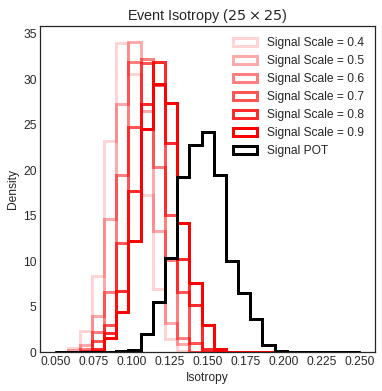

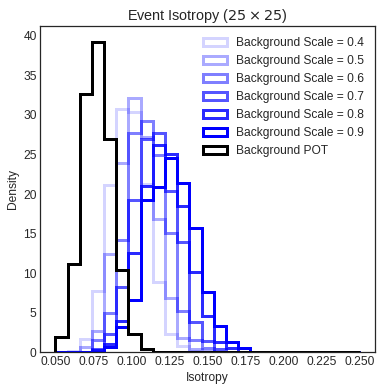

In [28]:
plt.figure(figsize=(6, 6))
plt.rcParams['font.size'] = '12'

for j in range(1):
    for (e, eps) in enumerate(epsilons):
        print(np.mean(emds_sinkhorn[0,j,e,:] ))
        # plt.hist(emds_old[0,j,:] * 0.5 / 0.8, bins = 25, range=(0.0, 1.125), density = True, color = "red", label = "Signal Old", histtype="stepfilled", alpha = 0.5)
        plt.hist(emds_sinkhorn[0,j,e,:] , bins = 25, range=(0.05, 0.25), density = True, color = "red", label = "Signal Scale = %.1f" % eps, histtype="step", alpha = (1 + e) / len(epsilons), lw = 3)
    print(np.mean(emds_old[0,:] /2))
    plt.hist(emds_old[0,:] /2, bins = 25, range=(0.05, 0.25), density = True, color = "Black", label = "Signal POT", histtype="step", lw = 3)
    plt.title(r"Event Isotropy ($25\times25$)" )
    plt.xlabel(r"Isotropy" )
    plt.ylabel(r"Density" )
    plt.legend()
    plt.savefig("Plots/signal_annealing.pdf")
    plt.show()
    
plt.figure(figsize=(6, 6))
plt.rcParams['font.size'] = '12'

for j in range(1):
    for (e, eps) in enumerate(epsilons):

        # plt.hist(emds_old[1,j,:] * 0.5 / 0.8, bins = 25, range=(0.0, 1.125), density = True, color = "blue", label = "Background Old", histtype="stepfilled", alpha = 0.5)
        plt.hist(emds_sinkhorn[1,j,e,:] , bins = 25, range=(0.05, 0.25), density = True, color = "blue", label = "Background Scale = %.1f" % eps, histtype="step", alpha = (1 + e) / len(epsilons), lw = 3)
    plt.hist(emds_old[1,:] / 2, bins = 25, range=(0.05, 0.25), density = True, color = "Black", label = "Background POT", histtype="step", lw = 3)
    plt.title(r"Event Isotropy ($25\times25$)")
    plt.xlabel(r"Isotropy")
    plt.ylabel(r"Density" )
    plt.legend( )
    plt.savefig("Plots/backgrounds_annealing.pdf")
    plt.show()

# for j in range(3):
#     plt.hist(emds_old[1,j,:] * 0.5 / 0.8 , bins = 25, range=(0.0, 1.125), density = True, color = "blue", label = "Background Old", histtype="stepfilled", alpha = 0.5)
#     plt.hist(emds_sinkhorn[1,j,:] * 0.5 / 0.8, bins = 25, range=(0.0, 1.125), density = True, color = "darkblue", label = "Background Sinkhorn", histtype="stepfilled", alpha = 0.5)
#     plt.title(r"$\tau_{%d}$" % (j+1))
#     plt.xlabel(r"$\tau_{%d}$" % (j+1))
#     plt.legend()
#     plt.show()


In [20]:
train(example_signal, _1point, lr = 0.05, early_stopping= 50, epsilon = 0.001)

RuntimeError: expected scalar type Double but found Float

In [ ]:
# # Compare OLD vs Sinkhorn learned values

# observables = [ 
#         _1subjettiness,
#         _2subjettiness,
#         _3subjettiness,
#   ]
# for (j, obs) in enumerate(observables):

#         params = obs.calculate(example_signal, training_config_dict, plot_filename="temp/test_%i.png" % j)
#         print(params)


# _1point = MixtureModel(shapes = [CoolPoint((-0.01397785,-0.04141136), 1.0)])
# _2point = MixtureModel(shapes = [CoolPoint((-0.01696394,0.04604918), 0.7235), CoolPoint((0.395,0.0535), 0.276)])
# _3point = MixtureModel(shapes = [CoolPoint((-0.01759723, -0.04697237), 0.492), CoolPoint((0.30403854, 0.05707067), 0.2759), CoolPoint((-0.33928187,  0.00147795), 0.2312)])
_3point = MixtureModel(shapes = [CoolPoint((-1.0,0.0), 0.333), CoolPoint((1.0,0.0), 0.333), CoolPoint((0.0,0,0), 0.333)])


# print(train(example_signal, _1point, epochs = 1, lr = 0.00, epsilon = 0.01, init = True))
# print(train(example_signal, _2point, epochs = 1, lr = 0.00, epsilon = 0.01, init = True))
print(train(example_signal, _3point, epochs = 100, lr = 0.05, epsilon = 0.01, init = True))

# print(train(event, _3point, epochs = 500, lr = 0.05, epsilon = 0.01))

